# Replica paper skin (ISIC2017 seborrheic task)

## 1. Import packages

In [1]:
################### Basic packages
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
from tqdm import tqdm_notebook
import PIL
#import cv2
from scipy.stats import skew, kurtosis                         # Color feature (3rd moment)
from skimage.feature.texture import greycomatrix, greycoprops  # Texture features
from skimage.measure import shannon_entropy                    # Texture features (entropy)

################### ML packages
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression  # Logistic regression
from sklearn.svm import SVC                          # Support vector machine
from sklearn.neural_network import MLPClassifier     # Multilayer perceptron
from sklearn.decomposition import KernelPCA          # Kernel PCA

################### DL packages
import torch
import torch.nn as nn
import torch.utils.data as tdatautils
import fastai
from   fastai.vision import *

%matplotlib inline
print("Versions:")
print("\tPillow       ", PIL.__version__)
print("\tScikit-learn ", sklearn.__version__)
print("\tPytorch      ", torch.__version__)
print("\tFast.ai      ", fastai.__version__)

Versions:
	Pillow        5.4.1
	Scikit-learn  0.20.1
	Pytorch       1.0.1
	Fast.ai       1.0.48


## 2. Read data

In [2]:
#TASK = "melanoma"
TASK = "seborrheic_keratosis"

path     = pathlib.Path("E:/Datasets/TFM/ISIC-2017")
df_train = pd.read_csv(path / ("ground_truth_train.csv"))
df_valid = pd.read_csv(path / ("ground_truth_valid.csv"))
df_test  = pd.read_csv(path / ("ground_truth_test.csv"))

print("Train dataset", len(df_train), "images.")
print("Valid dataset", len(df_valid), "images.")
print("Test  dataset", len(df_test), "images.")

#df = df.replace({'melanoma': {0.0:"no", 1.0:"yes"}})
df_train[["melanoma", "seborrheic_keratosis"]] = df_train[["melanoma", "seborrheic_keratosis"]].astype(int)
df_valid[["melanoma", "seborrheic_keratosis"]] = df_valid[["melanoma", "seborrheic_keratosis"]].astype(int)
df_test[ ["melanoma", "seborrheic_keratosis"]] = df_test[ ["melanoma", "seborrheic_keratosis"]].astype(int)

# Merge
#df = pd.concat([df_train, df_valid, df_test], ignore_index=True)

print("\nFirst 5 rows of the train dataset:")
df_train.head()

Train dataset 2000 images.
Valid dataset 150 images.
Test  dataset 600 images.

First 5 rows of the train dataset:


,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0,0
1,ISIC_0000001,0,0
2,ISIC_0000002,1,0
3,ISIC_0000003,0,0
4,ISIC_0000004,1,0


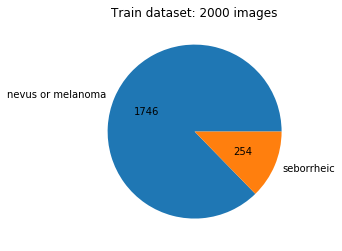

In [3]:
pct = lambda p: '{:.0f}'.format(p * 2000 / 100)
labels = ["nevus or melanoma", 'seborrheic']
df_train[TASK].value_counts().plot.pie(labels=labels, autopct=pct); plt.ylabel('')
plt.title('Train dataset: 2000 images');

## 3. Preprocess dataset
- Compute average **mean** and **std** of the images for normalize later
- Stratified 10 fold cross validation
- Transform to get a 140x140 size
- Random horizontal and vertical flips

In [4]:
###################################### Stratified 10 Fold Cross validation indexes
n_cv_folds = 10
x = df_train["image_id"].values
y = df_train[TASK].values
train_idxs_fold = []
valid_idxs_fold = []

cross_valid = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=0) # Always same random stratified CV
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    train_idxs_fold.append(train_index)
    valid_idxs_fold.append(valid_index)

###################################### Get mean and std
#mean = np.zeros(3)  # float64
#std  = np.zeros(3)  # float64
#for img in tqdm_notebook(train):
#    mean += img.data.numpy().mean(axis=(1,2)) # float32
#    std  += img.data.numpy().std(axis=(1,2)) 
#mean /= len(train)
#std  /= len(train)
ISIC2017_mean  = [0.689854, 0.585559, 0.543878]
ISIC2017_std   = [0.10585 , 0.114173, 0.127212]

##################################### Src data
src_train = ImageList.from_df(df_train, path, folder='data_train', suffix=".jpg")
src_valid = ImageList.from_df(df_valid, path, folder='data_valid', suffix=".jpg")
src_test  = ImageList.from_df(df_test,  path, folder='data_test',  suffix=".jpg")

data = (src_train.split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0]) # src_train.no_split(); src.valid = valid
        .label_from_df(cols=TASK)
        .transform(get_transforms(flip_vert=True, max_warp=None), size=140)
        .databunch(bs=16)
        .normalize((ISIC2017_mean, ISIC2017_std)))

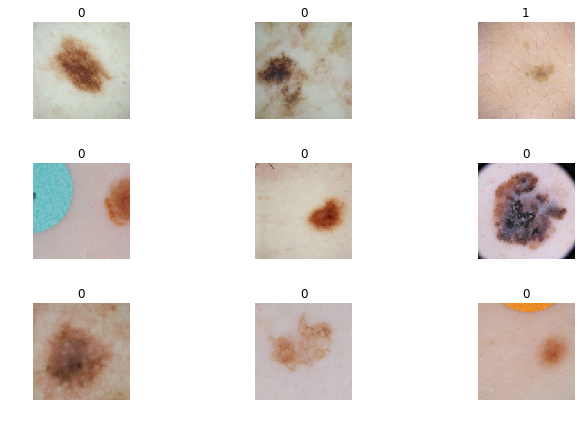

In [5]:
data.show_batch(rows=3, figsize=(10,6))

### Auxiliary funcs

In [5]:
def plot_auc(y_valid, y_pred, ax=None, figsize=(5,5)):

    if ax is None: fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    ax.set_title('ROC Curve')
    ax.plot(fpr, tpr, 'darkorange', label = 'AUC = %0.4f' % roc_auc)
    ax.legend(loc = 'lower right', fontsize="large")
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlim([-0.005, 1])
    ax.set_ylim([0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return ax

def cv_auc(model, x, y):

    preds_abs   = np.array([])
    preds_probs = np.array([])
    reals       = np.array([])

    for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):

        ########################################################## GET K-FOLD DATA
        x_train, y_train = x[train_index], y[train_index]
        x_valid, y_valid = x[valid_index], y[valid_index]

        ########################################################## TRAIN
        model.fit(x_train, y_train)

        ########################################################## EVALUATE
        p  = model.predict(x_valid)
        pp = model.predict_proba(x_valid)[:,1]
        preds_abs   = np.append(preds_abs,   p)
        preds_probs = np.append(preds_probs, pp)
        reals       = np.append(reals,       y_valid)
        print("Fold", i+1, "  AUC:", metrics.roc_auc_score(y_valid, pp))


    print("================================")
    print("AUC:             ", metrics.roc_auc_score(reals, preds_probs))
    print("Accuracy:        ", metrics.accuracy_score(reals, preds_abs))
    print("Accuracy (balan):", metrics.balanced_accuracy_score(reals, preds_abs))
    #print("F1 score:        ", metrics.f1_score(reals, preds_abs))
    #print("Precision:      ", metrics.precision_score(reals, preds_abs))
    #print("Recall:         ", metrics.recall_score(reals, preds_abs))
    print("Confusion matrix:\n", metrics.confusion_matrix(reals, preds_abs))
    plot_auc(reals, preds_probs)
    return reals, preds_probs

# Models
- Trad feats (color & texture) with **SVM**
- Deep feats (CNN penultimate layer) with **Coding network**
- Fusion methods (both trad & deep feats)
  - **CNMP**: (multilayer perceptron as fusion method)
  - **R**: (manully fixed parameter) (log regr)
  - **KPCA**: KPCA and linear SVM
  - **SVM**: RBF SVM
  
  
# MODEL 1: SVM with trad feats
### Objetive `72.09%`  -> Obtained `87.31%`

In [92]:
x = np.load('features/skinTrain_x_low.npy')
x = StandardScaler().fit_transform(x)
y = df_train[TASK].values

print("Data shape: x =", x.shape, "y =", y.shape)

Data shape: x = (2000, 33) y = (2000,)


Fold 1   AUC: 0.8125274725274725
Fold 2   AUC: 0.8413186813186813
Fold 3   AUC: 0.8432967032967033
Fold 4   AUC: 0.8074725274725274
Fold 5   AUC: 0.8310857142857143
Fold 6   AUC: 0.8619428571428571
Fold 7   AUC: 0.9151724137931034
Fold 8   AUC: 0.9181609195402298
Fold 9   AUC: 0.8262068965517242
Fold 10   AUC: 0.8466666666666667
AUC:              0.8488964652614299
Accuracy:         0.8345
Accuracy (balan): 0.7100842420470637
Confusion matrix:
 [[1531  215]
 [ 116  138]]


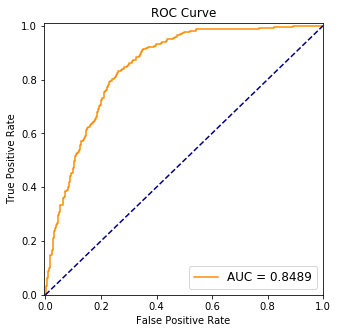

In [94]:
model = SVC(kernel='rbf', class_weight='balanced', C=1,  gamma=0.1, probability=True, random_state=0) # 
#model = SVC(kernel='rbf', class_weight='balanced', C=1, gamma='scale', probability=True, random_state=0) # 0.8676
#model = SVC(kernel='rbf', class_weight='balanced', C=10,  gamma=0.001, probability=True, random_state=0) # 0.8722
#model = SVC(kernel='rbf', class_weight='balanced', C=1000, gamma=0.001, probability=True, random_state=0) # 0.8731
r, trad_pred = cv_auc(model, x, y)

# MODEL 2: Coding Network (cnn) TRAINED WITH MELA CV-STRAT
### Objetive `80.87%`  -> Obtained `81.38%`

Input size of `3×140×140`

Layer       | Kernel | Stride | Output size
------------|--------|--------|------------
Convolution | 11×11  |    1   | 32×130×130
Convolution | 11×11  |    1   | 32×120×120
Max pooling | 5×5    |    2   | 32×58×58
Convolution | 9×9    |    1   | 64×50×50
Max pooling | 5×5    |    2   | 64×23×23
Convolution | 8×8    |    1   | 128×16×16
Convolution | 9×9    |    1   | 256×8×8
Convolution | 8×8    |    1   | 256×1×1
Dense       |    -   |    -   | 4×1×1
Softmax     |    -   |    -   | 4×1×1

In [96]:
##################################################### Fastai AUC ROC fix
def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return metrics.roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_target, last_output, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            self.learn.recorder.add_metrics([metric])

In [106]:
def conv(in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0),
        nn.BatchNorm2d(out_channels),
        # nn.Dropout2d(p=0.05),
        nn.ReLU())

CodingNetwork = nn.Sequential(
	conv(3,  32, kernel_size=11),
	conv(32, 32, kernel_size=11),
	nn.MaxPool2d(kernel_size=5, stride=2, padding=0),
	conv(32, 64, kernel_size=9),
	nn.MaxPool2d(kernel_size=5, stride=2, padding=0),
	conv(64,  128, kernel_size=8),
	conv(128, 256, kernel_size=9),
	conv(256, 256, kernel_size=8),
	Flatten(),
	nn.Linear(256, 2)
)

learn = Learner(data, CodingNetwork, metrics=accuracy, callback_fns=AUROC)
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 32, 130, 130]    11,648     True      
______________________________________________________________________
BatchNorm2d          [1, 32, 130, 130]    64         True      
______________________________________________________________________
ReLU                 [1, 32, 130, 130]    0          False     
______________________________________________________________________
Conv2d               [1, 32, 120, 120]    123,936    True      
______________________________________________________________________
BatchNorm2d          [1, 32, 120, 120]    64         True      
______________________________________________________________________
ReLU                 [1, 32, 120, 120]    0          False     
______________________________________________________________________
MaxPool2d            [1, 32, 58, 58]      0          False     
______________________________________________________________

### Balance loss function (class-weighted CrossEntropyLoss)

In [107]:
df_train[TASK].value_counts()

0    1746
1     254
Name: seborrheic_keratosis, dtype: int64

In [108]:
weights1 = [1/1746,   1/254]      # Option 1 [0.0006, 0.0040]
weights2 = [254/2000, 1746/2000]  # Option 2 [0.127,  0.873]
weights  = torch.FloatTensor(weights2).cuda()

learn.loss_func = CrossEntropyFlat(weight=weights)

### Find best maximun learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


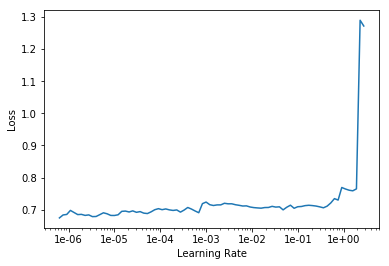

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(45, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,AUROC,time
1,0.648695,0.626601,0.666667,0.659209,03:27
2,0.624952,0.604475,0.711443,0.695451,03:22
3,0.613288,0.785960,0.746269,0.697670,03:20
4,0.614861,0.579640,0.820895,0.723003,03:18
5,0.609312,0.582286,0.761194,0.709689,03:20
6,0.627431,0.606452,0.686567,0.688055,03:16
7,0.613498,0.615204,0.552239,0.721154,03:16
8,0.624886,0.929068,0.781095,0.587463,03:17
9,0.600507,0.665317,0.736318,0.683987,03:17
10,0.620611,0.651069,0.736318,0.691198,03:17


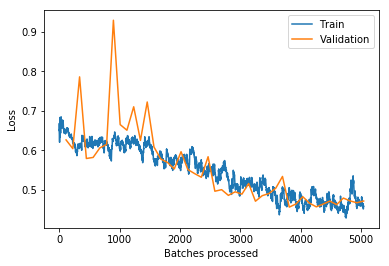

In [21]:
learn.recorder.plot_losses()

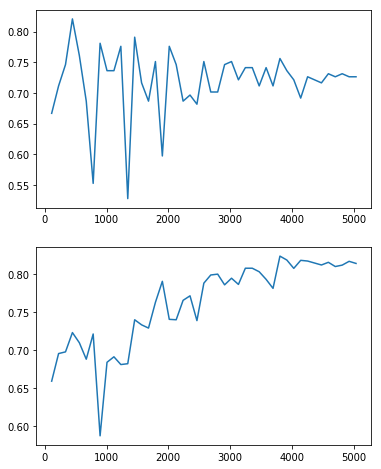

In [22]:
learn.recorder.plot_metrics() # First is accuracy, second is AUC

In [23]:
learn.save("Sebor-45eps-Fold1")

## Test

In [109]:
learn.load("Sebor-45eps-Fold1");

In [110]:
preds,    y    = learn.get_preds()
cn_pred = preds[:,1].numpy()
cn_real = y.numpy()

Accuracy:  0.7263681592039801
AUC ROC:   0.8137943786982248
F1 score:  0.47619047619047616
Precision: 0.3424657534246575
Recall:    0.78125
Confusion matrix:
 [[121  48]
 [  7  25]]


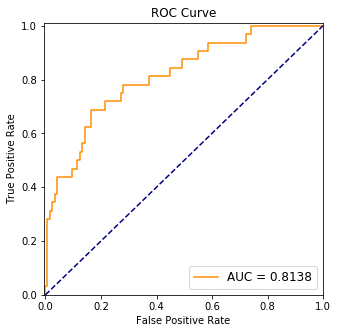

In [111]:
print("Accuracy: ", metrics.accuracy_score(cn_real, cn_pred.round()))
print("AUC ROC:  ", metrics.roc_auc_score(cn_real, cn_pred))
print("F1 score: ", metrics.f1_score(cn_real, cn_pred.round()))
print("Precision:", metrics.precision_score(cn_real, cn_pred.round()))
print("Recall:   ", metrics.recall_score(cn_real, cn_pred.round()))
print("Confusion matrix:\n", metrics.confusion_matrix(cn_real, cn_pred.round()))
plot_auc(cn_real, cn_pred);

Accuracy:  0.7263681592039801
AUC ROC:   0.8137943786982248
F1 score:  0.47619047619047616
Precision: 0.3424657534246575
Recall:    0.78125
Confusion matrix:
 [[121  48]
 [  7  25]]


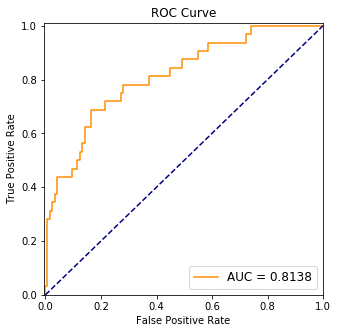

In [25]:
print("Accuracy: ", metrics.accuracy_score(cn_real, cn_pred.round()))
print("AUC ROC:  ", metrics.roc_auc_score(cn_real, cn_pred))
print("F1 score: ", metrics.f1_score(cn_real, cn_pred.round()))
print("Precision:", metrics.precision_score(cn_real, cn_pred.round()))
print("Recall:   ", metrics.recall_score(cn_real, cn_pred.round()))
print("Confusion matrix:\n", metrics.confusion_matrix(cn_real, cn_pred.round()))
plot_auc(cn_real, cn_pred);

## Save high (cnn) features

In [42]:
data = (src_train.no_split()
        .label_from_df(cols='seborrheic_keratosis')
        .transform(([],[]), size=140)
        .databunch(bs=128)
        .normalize((ISIC2017_mean, ISIC2017_std)))

In [44]:
def high_features(dataset, model):
    
    num_samples = len(dataset)
    h_feats = np.empty([num_samples, 256])
        
    for i in tqdm_notebook(range(num_samples)):
        
        img_tnsr   = dataset[i][0].data.cuda()[None,:]         # [1, 3, 140, 140] cuda tensor
        h_feats[i] = model(img_tnsr)[0].cpu().detach().numpy() # [256] cpu numpy

    return h_feats

h_feats = high_features(data.train_ds, learn.model.eval()[:-1])
np.save('features/skinTrain_x_highSebo.npy', h_feats)

# Fusion methods

In [83]:
x_low  = np.load('features/skinTrain_x_low.npy')
#x_low = preprocessing.scale(low)
x_low  = preprocessing.StandardScaler().fit_transform(x_low) # Normalice
x_high = np.load('features/skinTrain_x_highSebo.npy')

x      = np.concatenate((x_low, x_high), axis=1)
y      = df_train[TASK].values


############################## Split in train-val
train_idxs = train_idxs_fold[0]
valid_idxs = valid_idxs_fold[0]
x_train, y_train = x[train_idxs], y[train_idxs]
x_valid, y_valid = x[valid_idxs], y[valid_idxs]

print("Low features:\tShape:", x_low.shape,   "\t Min:", x_low.min(), "\t Max:", x_low.max())
print("High features:\tShape:", x_high.shape, "\t Min:", x_high.min(), "\t\t\t Max:", x_high.max())
print("Fusion feats:\tShape:", x.shape,       "\t Min:", x.min(),      "\t Max:", x.max())

Low features:	Shape: (2000, 33) 	 Min: -5.011059247850769 	 Max: 11.601424261926983
High features:	Shape: (2000, 256) 	 Min: 0.0 			 Max: 2.5767552852630615
Fusion feats:	Shape: (2000, 289) 	 Min: -5.011059247850769 	 Max: 11.601424261926983


# Fusion: R
### Objetive `94.36%`  -> Obtained `88.64%`

Fold 1   AUC: 0.8830769230769231
Fold 2   AUC: 0.8964835164835164
Fold 3   AUC: 0.8608791208791209
Fold 4   AUC: 0.8265934065934066
Fold 5   AUC: 0.8934857142857143
Fold 6   AUC: 0.8683428571428571
Fold 7   AUC: 0.9390804597701149
Fold 8   AUC: 0.8988505747126437
Fold 9   AUC: 0.9211494252873562
Fold 10   AUC: 0.9029885057471264
AUC:              0.8864446067952847
Accuracy:         0.8005
Accuracy (balan): 0.8150891576697242
Confusion matrix:
 [[1389  357]
 [  42  212]]


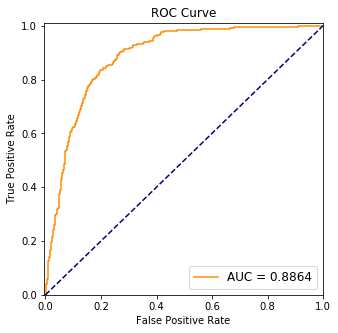

In [71]:
#model = LogisticRegression(C=1e6, solver='lbfgs', class_weight='balanced', max_iter=10000, random_state=0)
model = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000, random_state=0)
r, r_pred = cv_auc(model, x, y)

# Fusion: MLP
### Objetivo `95.85%` -> Obtengo `84.24`

[tut](https://forums.fast.ai/t/data-block-api-to-read-numpy-arrays/36065/3)

Fold 10   AUC: 0.8887356321839079
Final AUC:        0.8774724680033553


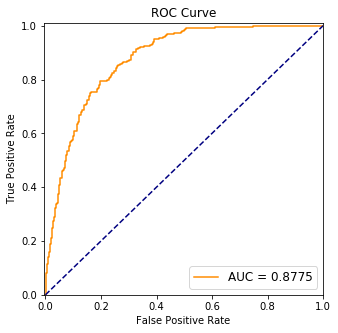

In [65]:
learn = 0
cnmp_pred = np.array([])
cnmp_real = np.array([])
    
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):

    ########################################################## GET K-FOLD DATA (numpy)
    x_train, y_train = x[train_index], y[train_index]
    x_valid, y_valid = x[valid_index], y[valid_index]
    
    ########################################################## Get tensor datasets
    train_ds = tdatautils.TensorDataset(torch.from_numpy(x_train).to(torch.float32),
                                        torch.from_numpy(y_train).to(torch.int64))
    valid_ds = tdatautils.TensorDataset(torch.from_numpy(x_valid).to(torch.float32),
                                        torch.from_numpy(y_valid).to(torch.int64))
    
    ########################################################## Get databunch
    batch_size = 128
    dataFusion = DataBunch.create(train_ds, valid_ds, bs=batch_size)

    ########################################################## Define net
    H   = 200
    net = nn.Sequential(nn.Linear(x.shape[1], H),
                        nn.BatchNorm1d(H),
                        nn.ReLU(),
                        nn.Linear(H, 2)).cuda()
    
    ########################################################## Train
    learn = Learner(dataFusion, net, metrics=accuracy, loss_func=CrossEntropyFlat(weights))
    #learn.lr_find()
    #learn.recorder.plot()
    learn.fit_one_cycle(5, 1e-1)
    
    ########################################################## Test
    pred, real = learn.get_preds()
    pred      = pred[:,1].numpy()
    real      = real.numpy()
    cnmp_pred = np.append(cnmp_pred, pred)
    cnmp_real = np.append(cnmp_real, real)
    print("Fold", i+1, "  AUC:", metrics.roc_auc_score(real, pred))
    
print("================================")
print("Final AUC:       ", metrics.roc_auc_score(cnmp_real, cnmp_pred))
plot_auc(cnmp_real, cnmp_pred)

Fold 1   AUC: 0.8424175824175825
Fold 2   AUC: 0.8683516483516485
Fold 3   AUC: 0.8742857142857143
Fold 4   AUC: 0.8259340659340659
Fold 5   AUC: 0.8841142857142856
Fold 6   AUC: 0.8452571428571429
Fold 7   AUC: 0.9406896551724139
Fold 8   AUC: 0.9160919540229886
Fold 9   AUC: 0.8728735632183908
Fold 10   AUC: 0.8845977011494253
AUC:              0.8423889024181256
Accuracy:         0.8805
Accuracy (balan): 0.6691447718519721
Confusion matrix:
 [[1663   83]
 [ 156   98]]


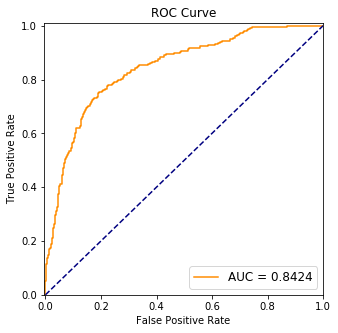

In [17]:
#model = MLPClassifier(hidden_layer_sizes=(200), max_iter=1000, validation_fraction=0, random_state=0) # 150, 200 hl works good
model = MLPClassifier(hidden_layer_sizes=200, max_iter=1000, random_state=0)
r, p4 = cv_auc(model, x, y)

# Fusion: SVM
### Objetivo `82.10%`  -> Obtengo `87.83%`

Fold 1   AUC: 0.8525274725274725
Fold 2   AUC: 0.8958241758241758
Fold 3   AUC: 0.870989010989011
Fold 4   AUC: 0.8347252747252747
Fold 5   AUC: 0.9046857142857143
Fold 6   AUC: 0.8429714285714286
Fold 7   AUC: 0.9459770114942528
Fold 8   AUC: 0.8917241379310344
Fold 9   AUC: 0.87816091954023
Fold 10   AUC: 0.8760919540229886
AUC:              0.878336084278125
Accuracy:         0.798
Accuracy (balan): 0.796835962514995
Confusion matrix:
 [[1394  352]
 [  52  202]]


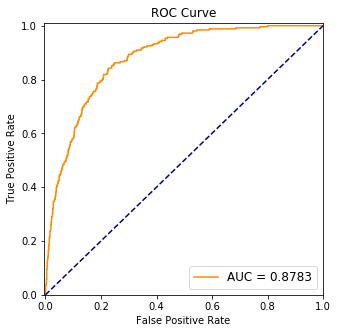

In [90]:
#model = SVC(class_weight='balanced', probability=True)                                                   # 
#model = SVC(kernel='rbf', class_weight='balanced', C=1, gamma='scale', probability=True, random_state=0) # 
#model = SVC(kernel='rbf', class_weight='balanced', C=10,  gamma=0.001, probability=True, random_state=0) # 
model = SVC(kernel='rbf', class_weight='balanced', C=1000, gamma=0.001, probability=True, random_state=0) # 0.8783
r, svm_pred = cv_auc(model, x, y)

# Fusion: KPCA
### Objetivo `93.26%`  -> Obtengo `%`

Fold 1   AUC: 0.8646153846153846
Fold 2   AUC: 0.8923076923076922
Fold 3   AUC: 0.8670329670329671
Fold 4   AUC: 0.8336263736263736
Fold 5   AUC: 0.8994285714285715
Fold 6   AUC: 0.8644571428571428
Fold 7   AUC: 0.9491954022988506
Fold 8   AUC: 0.9151724137931034
Fold 9   AUC: 0.906896551724138
Fold 10   AUC: 0.8974712643678161
AUC:              0.8873194974339549
Accuracy:         0.776
Accuracy (balan): 0.8161963002047424
Confusion matrix:
 [[1331  415]
 [  33  221]]


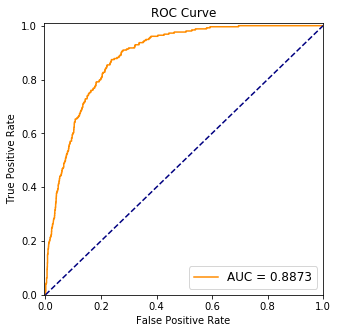

In [86]:
kpca   = KernelPCA(kernel="rbf")#, gamma=10)
x_kpca = kpca.fit_transform(x)

model = SVC(kernel='linear', C=10, gamma=0.1, class_weight='balanced', probability=True, random_state=0) # Linear SVM
r, kpca_pred = cv_auc(model, x_kpca, y)

# All models

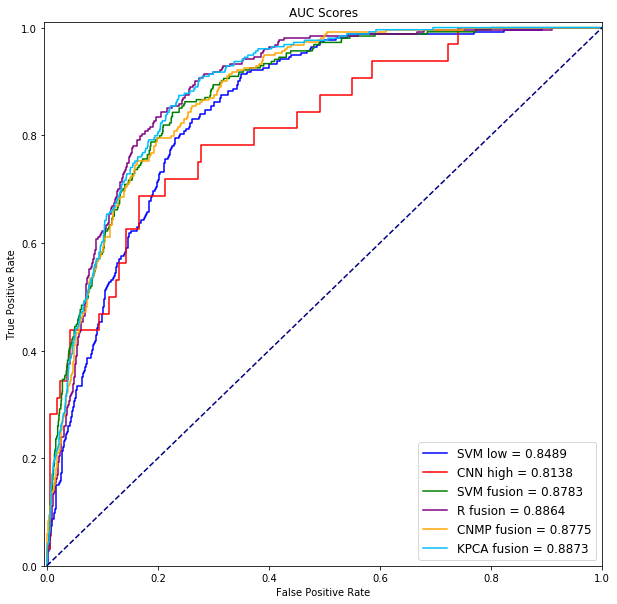

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

######################################################### M1
fpr, tpr, threshold = metrics.roc_curve(r, trad_pred); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="b", label = 'SVM low = %0.4f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(cn_real, cn_pred); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="r", label = 'CNN high = %0.4f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(r, svm_pred); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="g", label = 'SVM fusion = %0.4f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(r, r_pred); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="purple", label = 'R fusion = %0.4f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(r, cnmp_pred); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="orange", label = 'CNMP fusion = %0.4f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(r, kpca_pred); roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, color="deepskyblue", label = 'KPCA fusion = %0.4f' % roc_auc)

ax.set_title('AUC Scores')
ax.legend(loc = 'lower right', fontsize="large")
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlim([-0.005, 1])
ax.set_ylim([0, 1.01])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate');

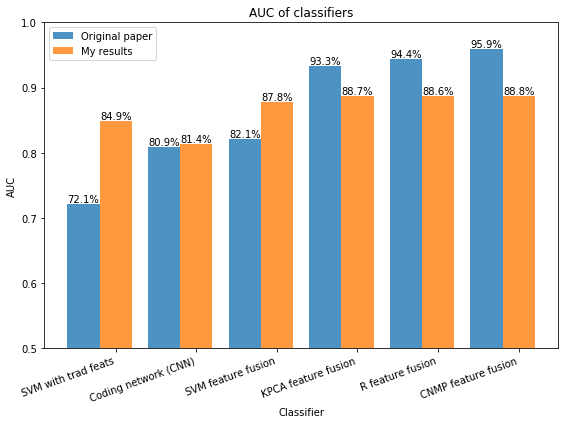

In [118]:
# data to plot
titles   = ['SVM with trad feats',
            'Coding network (CNN)',
            'SVM feature fusion',
            'KPCA feature fusion',
            'R feature fusion',
            'CNMP feature fusion']
acc_paper   = [0.7209, 0.8087, 0.8210, 0.9326, 0.9436, 0.9585]
acc_mine    = [0.8489, 0.8138, 0.8783, 0.8873, 0.8864, 0.8875]
n_models = 6

 
# create plot
fig, ax = plt.subplots(figsize=(8,6))
index = np.arange(n_models)
bar_width = 0.4
opacity = 0.8

rects1 = plt.bar(index, acc_paper, bar_width,
alpha=opacity,
label='Original paper')
 
rects2 = plt.bar(index + bar_width, acc_mine, bar_width,
alpha=opacity,
label='My results')

for x,y in zip(index, acc_paper):
    plt.text(x, y, "{:0.1f}%".format(y*100), ha='center', va='bottom')
    

for x,y in zip(index + bar_width, acc_mine):
    plt.text(x, y, "{:0.1f}%".format(y*100), ha='center', va='bottom')
    
plt.xlabel('Classifier')
plt.ylabel('AUC')
plt.title('AUC of classifiers')
plt.ylim(0.5,1)
plt.xticks(index + bar_width, titles, rotation=20, ha='right')
plt.legend()
 
plt.tight_layout()
plt.show()